# Newton's Method

An iterative method for finding the minimum of a twice differentiable function, $f$. Using first and second-order information (i.e., the gradient and Hessian of $f$) each iteration moves closer to the minimum $f(x^*)$ with the iterate
$$
x_{k+1} := x_k - h_k \nabla^2 f(x_k)^{-1} \nabla f(x_k),
$$
where $h_k$ is the step size of the $k^\text{th}$ iteration. This step size is typically chosen via backtracking line search.

Note that Newton's Method (AKA the Newton-Raphson Method) is originally a root-finding algorithm, using first-order information to find the values of $x$ such that $f(x) = 0$. In this sense, Newton's Method in optimization can be seen as finding the zeros of the gradient of a differentiable function $f$, which is a sufficient and necessary condition for being a global optimum for convex $f$.

#### Resources
- https://web.stanford.edu/class/ee364a/lectures/unconstrained.pdf
- https://see.stanford.edu/materials/lsocoee364a/hw7sol.pdf
- https://gist.github.com/jiahao/1561144

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Backtracking Line Search

Pseudocode (BV Algorithm 9.2)

---
**given** a function $f$, its gradient $\nabla f$, the current feasible iterate $x\in\mathbf{dom}f$, and parameters $\alpha\in(0,0.5)$, $\beta\in(0,1)$

$h := 1$

**while** $f(x - h\nabla f) > f(x) - \alpha h \nabla f(x)^\top \nabla f(x)$, &nbsp;&nbsp;&nbsp;&nbsp; $h := \beta h$

---

Consider this note on practical implementation by Boyd (BV, p. 465):

> By our convention that $f$ is infinite outside its domain, the inequality implies that $x - h\nabla fx(x)$. In a practical implementation, we first multiply $h$ by $\beta$ until $x - h\nabla fx(x)$; then we start to cehck whether the inequality $f(x - h\nabla f) > f(x) - \alpha h \nabla f(x)^\top \nabla f(x)$ holds.

In [2]:
def linesearch(x, f, gradf, v, alpha=0.05, beta=0.5):
    """Backtracking Line Search
    x: current point (nx1)
    f: function (nx1 -> 1)
    gradf: gradient of function (nx1 -> nx1) (i.e., tranpose of Jacobian of f)
    v: step direction (i.e., -grad or -hess\grad)
    alpha, beta: backtracking parameters
    """
    
    # don't run forever! Boyd says quality of line search isn't super important in practice anyways
    MAXITERS = 1000
    
    # initialize step size
    h = 1
    
    # ensure we are in dom f
    for _ in range(MAXITERS):
        # move along the line given the current step size
        step = x + h * v
        
        # calculate value of function
        fstep = f(step)
        
        if np.isnan(fstep) or np.isinf(fstep):
            h = beta * h
        else:
            break
       
    fprime = gradf(x).T @ v
    
    for _ in range(MAXITERS):
        # move along the line given the current step size
        step = x + h * v
               
        # calculate the convexity constraint inequality
        lhs = f(step)
        rhs = f(x) + alpha * h * fprime
        
        # inequality check
        if lhs > rhs:
            h = beta * h # make step smaller
        else:
            break       
    
    return h

## Implementation


In pseudocode, this algorithm can be written (BV Algorithm 9.3)

---
**given** a starting point $x\in\mathbf{dom}f$ and a tolerance $\epsilon > 0$.

**repeat**

1. *Compute the Newton decrement.* $\lambda^2 := \nabla f(x)^\top \nabla^2 f(x)^{-1} \nabla f(x)$
2. *Stopping criterion.* **quit** if $\lambda^2/2 \le \epsilon$.
3. *Line search.* Choose step size $h_k$ via line search
4. *Update.* $x := x - h\nabla^2 f(x)^{-1} \nabla f(x)$

---

In [3]:
def newton(x0, f, gradf, hessf,
            alpha=0.05, beta=0.5,
            MAXITERS=1000, NDTOL=1e-3, **kwargs):
    """Gradient Descent
    Move along the cost surface in the steepest descent direction until the minimum is found.
    x0: initialization point (nx1)
    f: function (nx1 -> 1)
    gradf: gradient of function (nx1 -> nx1) (i.e., tranpose of Jacobian of f)
    hessf: gradient of gradient of function (nx1 -> nxn)
    alpha, beta: backtracking line search params
    MAXITERS: maximum number of iterations for gradient descent
    NDTOL: termination criterion on newton decrement
    """
        
    # initialize
    x = x0
    vals = []
    steps = []
    
    for _ in range(MAXITERS):
        
        # evaluate function at current point
        vals.append(f(x))
    
        # calculate step direction
        v = -np.linalg.solve(hessf(x),gradf(x))
    
        # check termination criterion on Newton decrement
        lam2 = gradf(x).T @ v
        if np.abs(lam2) < NDTOL:
            break
    
        # find the best step size for this step
        h = linesearch(x, f, gradf, v, alpha, beta)
    
        # iterate
        x = x + h * v
        
        # save this step for later
        steps.append(h)
        
    return (vals, steps, x, f(x))

## Example

Consider the unconstrained problem
$$
\min f(x) = - \sum_{i=1}^m \log(1 - a_i^\top x) - \sum_{i=1}^n \log(1 - x_i^2)
$$
with $x\in\mathbb{R}^n$. Clearly, $\mathbf{dom}f = \{ x | a_i^\top x \le 1, |x_i| < 1 \}$.

We will generate a random problem with the following parameters

In [4]:
n = 1000
m = 2000
A = np.random.default_rng(seed=0).normal(0, 1, (m,n))

In [5]:
def f(x):
    return -np.sum(np.log(1 - A@x)) - np.sum(np.log(1-x**2))

The gradient of this function is
$$
\begin{align}
\nabla f(x) &= \sum_{i=1}^m(1-a_i^\top x)^{-1} a_i
+ 2\begin{bmatrix}(1-x_1^2)^{-1}x_1 & \cdots & (1-x_n^2)^{-1}x_n\end{bmatrix}^\top \\
&= A^\top
\begin{bmatrix}(1-a_1^\top x)^{-1}\\\vdots\\(1-a_m^\top x)^{-1}\end{bmatrix}
+ 2\,\text{diag}(x)
\begin{bmatrix}(1-x_1^2)^{-1}\\\vdots\\(1-x_n^2)^{-1}\end{bmatrix} \\
\end{align}
$$

The Hessian of $f$ is
$$
\begin{align}
\nabla^2 f(x) &= \sum_{i=1}^m(1-a_i^\top x)^{-2} a_i a_i^\top + 2\,\text{diag}
\begin{bmatrix}(1-x_1^2)^{-1}+2(1-x_1^2)^{-2}x_1^2\\\vdots\\(1-x_n^2)^{-1}+2(1-x_n^2)^{-2}x_n^2\end{bmatrix} \\
&= A^\top\text{diag}\begin{bmatrix}(1-a_1^\top x)^{-2}\\\vdots\\(1-a_m^\top x)^{-2}\end{bmatrix}A
+ 2\,\text{diag}
\begin{bmatrix}(1-x_1^2)^{-1}+2(1-x_1^2)^{-2}x_1^2\\\vdots\\(1-x_n^2)^{-1}+2(1-x_n^2)^{-2}x_n^2\end{bmatrix}
\end{align}
$$

In [6]:
def gradf(x):
    d = (1 - A@x)**(-1)
    e = (1 - x**2)**(-1)
    return A.T @ d + 2*np.diag(x) @ e

def hessf(x):
    d = (1 - A@x)**(-2)
    e = (1 - x**2)**(-1) + 2*(1 - x**2)**(-2) * x**2
    return A.T @ np.diag(d) @ A + 2 * np.diag(e)

We can check this anayltic gradient with `scipy`:

In [7]:
import scipy.optimize

x0 = np.zeros((n,))
scipy.optimize.check_grad(f, gradf, x0)

# could check hessian with autograd

0.00047191494985289326

In [8]:
vals, steps, xopt, fopt = newton(x0, f, gradf, hessf)

/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, '$f(x_k) - f(x^*)$')

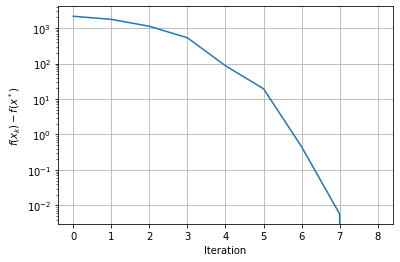

In [9]:
plt.semilogy(range(len(vals)), vals - fopt)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')

Text(0, 0.5, '$h_k$')

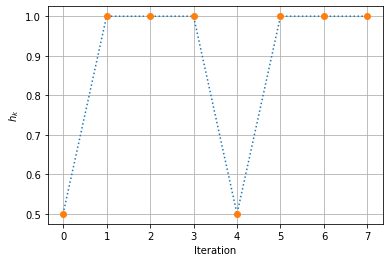

In [10]:
plt.plot(range(len(steps)), steps, ':')
plt.plot(range(len(steps)), steps, 'o')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('$h_k$')

/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/plusk01/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in

Text(0, 0.5, '$f(x_k) - f(x^*)$')

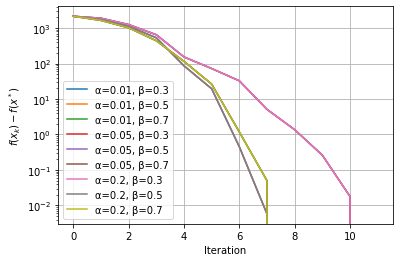

In [11]:
if 0:
    alphas = [0.01, 0.05, 0.2]
    betas = [0.3, 0.5, 0.7]
    for alpha in alphas:
        for beta in betas:
            vals, steps, _, fopt = newton(x0, f, gradf, hessf, alpha, beta)

            plt.semilogy(range(len(vals)), vals - fopt, label="α={}, β={}".format(alpha, beta))

    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('$f(x_k) - f(x^*)$')